**Dataset folder structure:**

The root folder '/content/drive/MyDrive/FARIL-SORG/cartilaginous-tumors-dataset' should contain two subfolders, "train" and "val", where the "train" folder contains two subfolders, "chondrosarcoma" and "enchondroma" and the "val" folder also contains two subfolders, "chondrosarcoma" and "enchondroma".

Each patient has a folder corresponding to their ID that contains their two images, should be placed in the appropriate subfolder. It's good practice to randomly split the patient data so that 80% of the patients are in the "train" folder and the remaining 20% are in the "val" folder.

With this folder structure, you can use the flow_from_directory method of the ImageDataGenerator class to automatically generate batches of images and labels for training and validation. This method will look into the subfolders and automatically label the images according to the folder they are in.

This lets you load the data by passing the path of the train and val folders to the flow_from_directory method.

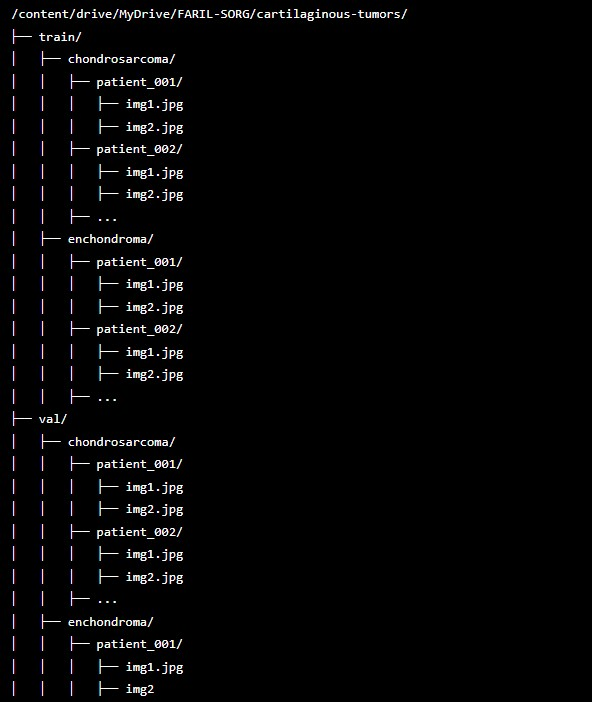

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
seed = 42
num_epochs = 50
batch_size = 16

# path to dataset on google drive
path_to_dataset = '/content/drive/MyDrive/FARIL-SORG/cartilaginous-tumors-dataset'

In [4]:
# create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values
    rotation_range=40,  # randomly rotate images by up to 40 degrees
    #rotation_range=10,  # randomly rotate images by up to 10 degrees
    width_shift_range=0.2,  # randomly shift images horizontally
    height_shift_range=0.2,  # randomly shift images vertically
    shear_range=0.2,  # randomly apply shearing transformations
    zoom_range=0.2,  # randomly zoom in and out
    #shear_range=0.1,  # randomly apply shearing transformations
    #zoom_range=0.1,  # randomly zoom in and out
    horizontal_flip=True,  # randomly flip images horizontally
    fill_mode='nearest')  # fill in newly created pixels

# create a generator for training data
train_generator = datagen.flow_from_directory(
    os.path.join(path_to_dataset, 'train'),  # directory containing training data
    target_size=(224, 224),  # resize images to 224x224 pixels
    batch_size=16, # modify the batch size
    shuffle=True,
    class_mode='categorical',
    seed=seed
)

# create a generator for validation data
val_generator = datagen.flow_from_directory(
    os.path.join(path_to_dataset, 'val'),  # directory containing validation data
    target_size=(224, 224),  # resize images to 224x224 pixels
    batch_size=16, # modify the batch size
    shuffle=True,
    class_mode='categorical',
    seed=seed
)

# specify the number of steps to take from the generator before moving to the next epoch
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

# Load InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# define two input layers for the two images
input_img1 = Input(shape=(224, 224, 3))
input_img2 = Input(shape=(224, 224, 3))

# Load InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Get output of InceptionResNetV2 model for image 1
x1 = base_model(input_img1)

# Get output of Xception model for image 2
x2 = base_model(input_img2)

# Concatenate the output
concatenated_output = concatenate([x1, x2])

# specify the weight decay rate
weight_decay = 1e-3

# add additional layers, and EXPERIMENT WITH DIFFERENT HYPERPARAMETERS
# Units: 128, 256, 512, 1024
# Dropout: min_value=0.0, max_value=0.5, step=0.1
# Learning rate: min_value=1e-4, max_value=1e-2, step=1e-4
# Weight decay: 0.001, 0.0001, 0.00001, 0.000001 (1e-3 to 1e-6)

# add additional layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=weight_decay)

# compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

Found 980 images belonging to 2 classes.
Found 236 images belonging to 2 classes.
219055592/219055592 [==============================] - 2s 0us/step


In [5]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=int(980/batch_size),
                              epochs=50,
                              validation_data=val_generator,
                              validation_steps=int(244/batch_size),
                              callbacks=[early_stop, model_checkpoint])

<ipython-input-5-34d441bc7861>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 1.6444 - acc: 0.5695
Epoch 1: val_loss improved from inf to 1.17169, saving model to best_model.h5
61/61 [==============================] - 347s 5s/step - loss: 1.6444 - acc: 0.5695 - val_loss: 1.1717 - val_acc: 0.5805
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 1.1115 - acc: 0.6349
Epoch 2: val_loss improved from 1.17169 to 1.10404, saving model to best_model.h5
61/61 [==============================] - 44s 723ms/step - loss: 1.1115 - acc: 0.6349 - val_loss: 1.1040 - val_acc: 0.6441
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 1.0427 - acc: 0.6753
Epoch 3: val_loss improved from 1.10404 to 1.10069, saving model to best_model.h5
61/61 [==============================] - 44s 721ms/step - loss: 1.0427 - acc: 0.6753 - val_loss: 1.1007 - val_acc: 0.6144
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 0.9990 - acc: 0.7261
Epoch 4: val_loss improved from 1.1006

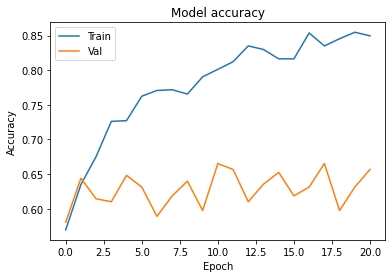

<function matplotlib.pyplot.legend(*args, **kwargs)>

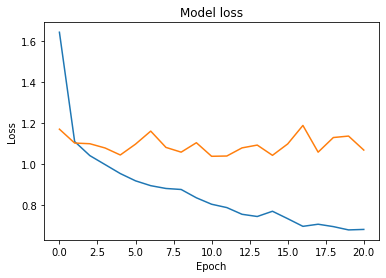

In [7]:
# import Matplotlib
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend

## Now let's apply Keras Tuner to optimize the hyperparameters automatically!

In [ ]:
import kerastuner

ModuleNotFoundError: ignored

In [ ]:
!pip install keras-tuner

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    # define two input layers for the two images
    input_img1 = Input(shape=(224, 224, 3))
    input_img2 = Input(shape=(224, 224, 3))

    # Load VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Get output of VGG16 model for image 1
    x1 = base_model(input_img1)

    # Get output of VGG16 model for image 2
    x2 = base_model(input_img2)

    # Concatenate the output
    concatenated_output = concatenate([x1, x2])

    # add additional layers
    x = concatenated_output
    x = Flatten()(x)
    x = Dense(hp.Int('units', 64, 256, step=32), activation='relu')(x)
    x = Dropout(hp.Float('dropout', 0, 0.5))(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=[input_img1, input_img2], outputs=predictions)
    model.compile(
        optimizer=optimizers.RMSprop(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='/content/drive/MyDrive/FARIL-SORG/cartilaginous-tumors-dataset/tuner',
    project_name='multiview_classification')

tuner.search(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps)

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


To create a web browser API for your trained model, you will need to use a web framework such as Flask or Django to create the API endpoint that will handle the incoming requests from the web browser. You will also need to use a web server such as Apache or Nginx to host the API.

##**Here is an example of how you might use Flask to create a web browser API for your model:**

First, install Flask and other necessary libraries in your colab notebook: